#  Mapping Print, Charting Enlightenment

##  Machine Learning Experiment 1: Classifying books by titles and other metadata

Team: Rachel Hendery, Tomas Trescak, Katie McDonough, Michael Falk, Simon Burrows

## Notebook 1: logistic regression on a DTM

Author: Michael Falk

In this notebook, I import the training data as a data table, and construct a document-term matrix. This is then used to train the first model, which isn't very good.

In [1]:
# Load libraries

import pandas as pd # for importing and manipulating data
import re # regex tools
import numpy as np # matematical functions
from nltk.tokenize import wordpunct_tokenize # tokeniser
from nltk.stem.snowball import SnowballStemmer # French stemmer
from sklearn.feature_extraction.text import CountVectorizer # for creating term-document matrix

In [2]:
# Import data

data = pd.read_csv("c:/git/mpce-machine-learning/data/editions_trimmed.csv").dropna()

data.head()

,full_book_title,stated_publication_places,number_of_volumes,parisian_keyword
0,"Abrégé de l'Histoire générale des voyages, con...",Paris,23,Histoire
1,Almanach des muses,n.pl.,1,Belles-Lettres
2,Art (l') de peindre sur l'émail,n.pl.,1,Science et Arts
3,"Apparat royal, dictionnaire françois et latin,...",n.pl.,1,Belles-Lettres
4,"Nouvelle (la) Académie des dames, ou histoire ...",n.pl.,1,Belles-Lettres


In [3]:
# Tokenise and normalise the title text

# Create stemming function
def fr_stemmer(token):
    '''Takes a token and stems it using the Snowball French stemmer'''
    return SnowballStemmer("french").stem(token)

title_strings_norm = [] # initialise list of word vectors
for title in data["full_book_title"]: # loop over titles
    title = title.lower() # make all letters lower case
    tokens = wordpunct_tokenize(title) # tokenise
    stems = list(map(fr_stemmer, tokens)) # stem the words
    reduced = [stem for stem in stems if len(stem) > 2] # strip out function words and punctuation marks
    title_string = " ".join(reduced) # concatenate into string, to be passed to CountVectorizer
    title_strings_norm.append(title_string) # append to results list

In [4]:
# Sanity check
import random
title_strings_norm[random.randint(1,len(title_strings_norm))]

'histoir gil blas santillan'

In [41]:
# Format data for ML algorithm

vec = CountVectorizer()
X = vec.fit_transform(title_strings_norm) # X is a dtm, of 3987 docs and 6343 words
y = list(data["parisian_keyword"]) 

In [6]:
print("X has %d rows and %d columns." % X.shape)
print("y has %d rows." % len(y))

X has 3838 rows and 6192 columns.
y has 3838 rows.


In [10]:
# Have a go with some simple classifiers

# Split into training and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=11)

# Use sklearn's logistic regression model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
lg = OneVsRestClassifier(estimator = LogisticRegression(max_iter = 100), n_jobs = 2) # initialise classifier
lg.fit(X_train, y_train) # fit to the training data
predictions = lg.predict(X_test) # compute predictions for the test data


 
The model classified 698 of the 960 examples correctly.
Accuracy = 72.2%


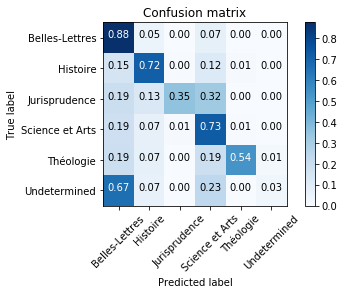

In [11]:
# Compute confusion matrix and accuracy (you need to execute the cell below to see the plot)
correct = predictions == y_test
accuracy = correct.sum()/len(correct)*100
print("\n \nThe model classified %d of the %d examples correctly." % (correct.sum(), len(correct)))
print("Accuracy = %d.2%%" % accuracy)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
plt.figure()
plot_confusion_matrix(cm, classes=lg.classes_, normalize = True)
plt.show()

In [8]:
# A function for plotting the confusion matrix, copied from scikit-learn.org
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    # else:
        # print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

This model is no good. After 1 iteration, it classfies the examples with 68% accuracy, and then after only two or three more iterations it converges on 70.2% and won't improve. We could compare it with a purely random model...

In [64]:
rand_y = y.copy()
np.random.shuffle(rand_y)
rand_correct = np.array(rand_y) == np.array(y)
rand_acc = 100*rand_correct.sum()/len(y)
print("Randomly shuffling the data predicts the correct label with %d.2%% accuracy." % rand_acc)

Randomly shuffling the data predicts the correct label with 27.2% accuracy.


We could try to fix up the simple classifier. We could try an SVM. We could get into the nuts and bolts and try to generate more complex features. I think the best option will be to try a deep neural net, and spend the time tuning that.